# Week 3 Box Jenkins Models
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/sktime/utils/validation/_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[

## 1. 30 pts - Regression Analysis

### 1.A - 5 pts Perform EDA (numerical, visual, descriptive)

In [2]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

In [3]:
df

,date,gdp,urate
0,1948-01-01,265.742,3.4
1,1948-04-01,272.567,3.9
2,1948-07-01,279.196,3.6
3,1948-10-01,280.366,3.7
4,1949-01-01,275.034,4.3
...,...,...,...
287,2019-10-01,21747.394,3.6
288,2020-01-01,21561.139,3.5
289,2020-04-01,19520.114,14.8
290,2020-07-01,21170.252,10.2


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gdp,292.0,6481.725808,6487.790355,265.742,802.66925,4046.9255,11011.904,21747.394
urate,292.0,5.779110,1.743680,2.600,4.50000,5.6000,6.825,14.800


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    292 non-null    datetime64[ns]
 1   gdp     292 non-null    float64       
 2   urate   292 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.0 KB


In [6]:
df.isnull().sum()

date     0
gdp      0
urate    0
dtype: int64

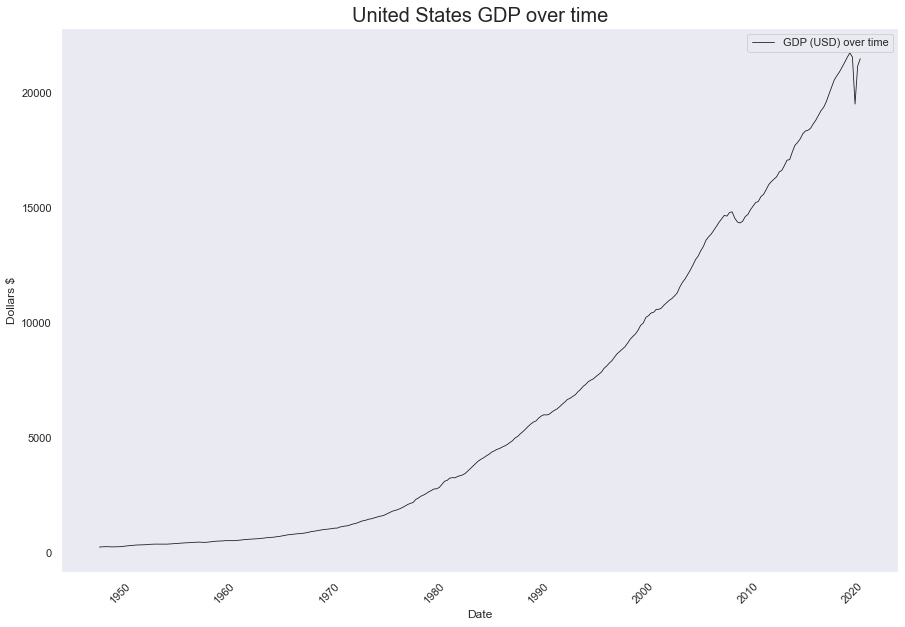

In [7]:
x = df['date']
#x = pd.to_datetime(x)

y = df['gdp']
# z = df['urate']

plt.figure(figsize=(15,10))  
plt.plot(x, y, color = 'k',label = "GDP (USD) over time", ls = '-', lw = 0.8)
#plt.plot(x, z, color = 'g',label = "SPY Price over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Dollars $')
plt.title('United States GDP over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

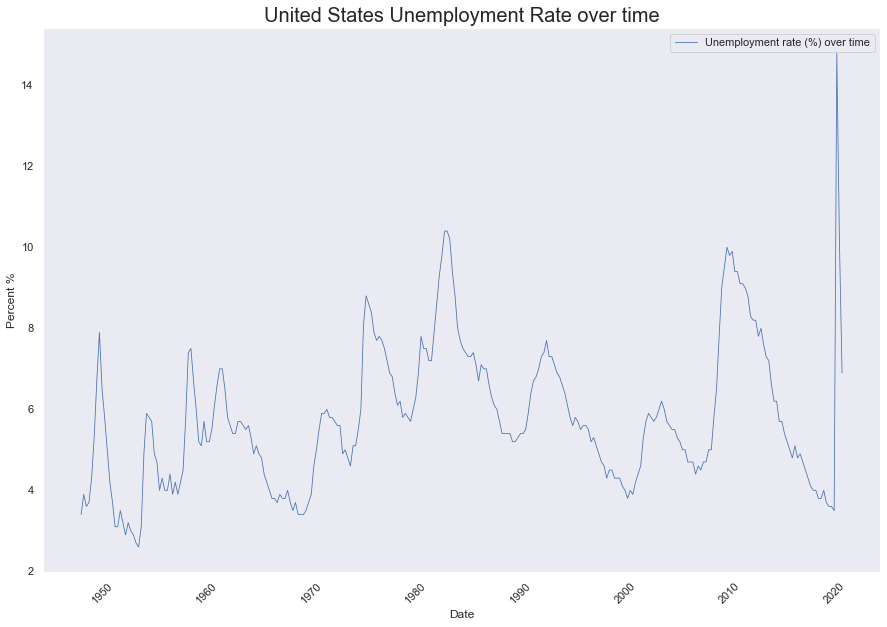

In [8]:
x = df['date']
z = df['urate']

plt.figure(figsize=(15,10))  
plt.plot(x, z, color = 'b',label = "Unemployment rate (%) over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Percent %')
plt.title('United States Unemployment Rate over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

In [9]:
# correlation table with all the numeric features
df.corr()

,gdp,urate
gdp,1.00000,0.14432
urate,0.14432,1.00000


<AxesSubplot:>

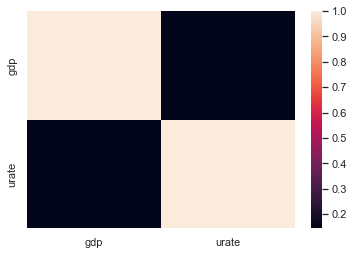

In [10]:
# heatmap based on the correlation table from above
sns.heatmap(df.corr())

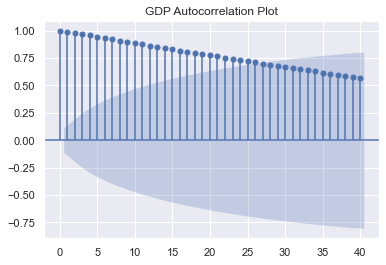

In [11]:
p = plot_acf(df['gdp'], lags=40, title='GDP Autocorrelation Plot')

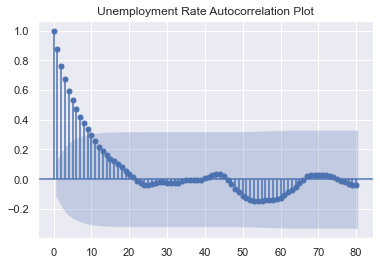

In [12]:
p = plot_acf(df['urate'], lags=80, title='Unemployment Rate Autocorrelation Plot')

### 1.B - 5 pts What is Okun’s Law? Does our dataset fit what we would expect to see? Why or why not?
- Okun's law looks at the statistical relationship between a country's unemployment and economic growth rates. Okun's law says that a country's gross domestic product (GDP) must grow at about a 4% rate for one year to achieve a 1% reduction in the rate of unemployment.
- Generally our dataset does not fit what we would expect to see because GDP is dependent on very many determining factors. We expect unemployment rate has no causation effect on GDP level. 

### 1.C - 5 pts Create a column that shows GDP change as a percentage and a column that shows UE rate as a change in percentage points. For date 4/1/1948 GDP change = 2.568, UE diff = 0.5

In [13]:
# set date as index
df.set_index('date', inplace = True)
# create new columns
df['gdp_pct_change'] = df['gdp'].pct_change()*100
df['urate_pct_pt_chg'] = df['urate'].diff()

df.head(len(df))
print(df.dtypes)

gdp                 float64
urate               float64
gdp_pct_change      float64
urate_pct_pt_chg    float64
dtype: object


In [14]:
# drop first row since it has NaN
df.dropna(subset = ['gdp_pct_change', 'urate_pct_pt_chg'], how='any',inplace=True)
df

,gdp,urate,gdp_pct_change,urate_pct_pt_chg
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-01-01,275.034,4.3,-1.901800,0.6
1949-04-01,271.351,5.3,-1.339107,1.0
...,...,...,...,...
2019-10-01,21747.394,3.6,0.961309,0.0
2020-01-01,21561.139,3.5,-0.856447,-0.1
2020-04-01,19520.114,14.8,-9.466221,11.3


### 1.D - 5 pts Split into Train/test ( ) and create a scatterplot, verifying the negative relationship in Okun’s law.

In [15]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(df)

In [16]:
y_train.index.min(), y_train.index.max()
y_test.index.min(), y_test.index.max()

(Timestamp('2002-10-01 00:00:00'), Timestamp('2020-10-01 00:00:00'))

In [17]:
print(y_train.shape)
print(y_test.shape)

(218, 4)
(73, 4)


gdp                -0.031490
urate               0.127573
gdp_pct_change     -0.528613
urate_pct_pt_chg    1.000000
Name: urate_pct_pt_chg, dtype: float64


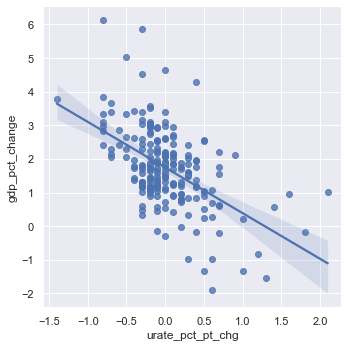

In [18]:
#df.plot.scatter(x='date', y='gdp', c='DarkBlue', title='GDP Over Time')
sns.lmplot(data = y_train, x = 'urate_pct_pt_chg', y = 'gdp_pct_change')
print(y_train.corr()['urate_pct_pt_chg'])

### 1.E - 5 pts Fit a linear model on the Training set. State Okun’s law using your data e.g. interpret the coefficients.
- We create a linear regression model whereas the equation of linear regression is y = 0 + 1X

- y is the target variable
- 0 is the intercept (linr_model.intercept_, or the weight predicted by the model). It is often referred to as the mean value of the target variable (y) when the regressor is zero (x = 0).
- linr_model.intercept_ equals 1.7436033729267004
- 1 is the regression coefficient or slope (- linr_model.coef_ in our model, again a predicted weight by model).
- linr_model.coef_ equals 'array([-1.35696971])', or -1.35696971.
- X is the regressor that helps in predicting the target.
- Here, the r2_score() is a function that gives you the coefficient of determination value. The actual and predicted values are set under the y_true and y_pred  arguments. Now see the output below to figure out how good your model is.
- Now here, you could see that the value for the coefficient of determination is 0.279431 which means the regressor (displacement) was able to explain 27.94% (almost 28%) of the variability of the target (gdp change). In other words, the predicted gdp values are almost 28% close to the actual gdp values. And this is not a good fit in this case.

In [19]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [20]:
y_train

,gdp,urate,gdp_pct_change,urate_pct_pt_chg
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-01-01,275.034,4.3,-1.901800,0.6
1949-04-01,271.351,5.3,-1.339107,1.0
...,...,...,...,...
2001-07-01,10596.294,4.6,-0.014418,0.2
2001-10-01,10660.294,5.3,0.603985,0.7
2002-01-01,10788.952,5.7,1.206890,0.4


In [21]:
#Setting target and regressor variables separate from dataframe
partial_y = y_train[["gdp_pct_change", "urate_pct_pt_chg"]]

partial_y

#Setting target and regression variables up
y = y_train.gdp_pct_change

X = y_train[["urate_pct_pt_chg"]]

In [22]:
#Fitting simple Linear Regression Model
linr_model = LinearRegression().fit(X, y)

linr_model

LinearRegression()

In [23]:
#Model Fitting Results
linr_model.coef_

array([-1.35696971])

In [24]:
linr_model.intercept_

1.7436033729267004

In [25]:
#Making Predictions based on the coefficient and intercept

linr_model.predict(y_train[["urate_pct_pt_chg"]])

array([ 1.06511852,  2.15069429,  1.6079064 ,  0.92942154,  0.38663366,
       -0.15615423,  0.11523972,  3.64336097,  2.69348217,  2.82917914,
        2.82917914,  2.42208823,  2.5577852 ,  1.74360337,  1.20081549,
        2.15069429,  2.15069429,  1.33651246,  2.01499732,  1.87930034,
        2.01499732,  1.87930034,  1.06511852, -0.69894211,  0.38663366,
        1.87930034,  1.87930034,  2.82917914,  2.01499732,  2.69348217,
        1.33651246,  2.15069429,  1.74360337,  1.20081549,  2.42208823,
        1.33651246,  2.15069429,  1.33651246,  1.33651246, -0.02045726,
       -0.42754817,  1.6079064 ,  2.82917914,  2.69348217,  2.82917914,
        1.87930034,  0.92942154,  2.42208823,  1.74360337,  1.33651246,
        0.92942154,  1.06511852,  1.20081549,  1.74360337,  2.42208823,
        2.69348217,  2.01499732,  2.01499732,  1.74360337,  1.33651246,
        1.74360337,  1.87930034,  1.87930034,  1.6079064 ,  2.15069429,
        2.28639126,  1.47220943,  2.01499732,  1.87930034,  2.28

In [26]:
#variation explained
r2_score(

    y_true = y_train.gdp_pct_change, 

    y_pred = linr_model.predict(y_train[["urate_pct_pt_chg"]])

)

0.2794316837078822

In [27]:
#pip install plotnine

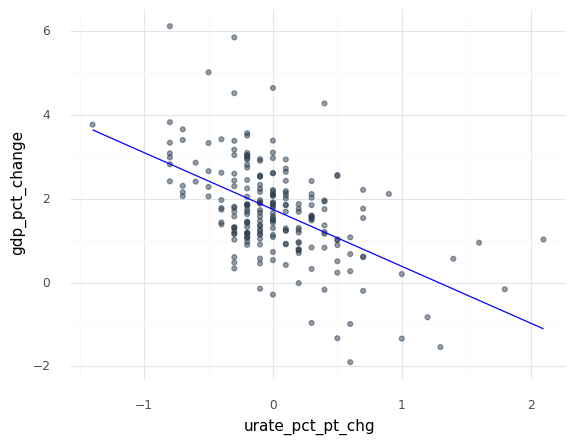

<ggplot: (8792158992535)>

In [28]:
#making custom visualization of mpg vs displacement

from plotnine import ggplot, aes, geom_point, geom_line
from plotnine.themes import theme_minimal

partial_y["fitted"] = linr_model.predict(y_train[["urate_pct_pt_chg"]])
partial_y

ggplot(aes("urate_pct_pt_chg", "gdp_pct_change" ), partial_y) \
+ geom_point(alpha = 0.5, color = "#2c3e50") \
+ geom_line(aes(y = "fitted"), color = 'blue') \
+ theme_minimal()

### 1.F - 5pts How can we use this model to predict level of GDP dollars in the future? What will we need, what are the resulting limitations?
- I don't think it's sufficient to only use this linear model to predict level of GDP dollars in the future. As we found in part 1E, our calculated value for the coefficient of determination is 0.279431 which means the regressor (displacement) was able to explain only 27.94% (almost 28%) of the variability of the target (gdp change). In other words, the predicted gdp values are almost 28% close to the actual gdp values. And this is not a good fit in this case.
- As you can imagine, GDP is dependent on very many determining factors. For example, natural resource levels, capital goods, human resources, and available technology are all factors affecting GDP levels. 
- There was nothing that indicated unemployment rate has a causation effect on GDP level. It seems unemployment rate is one factor that has very little impact on the outcome of GDP.

### Unfortunately, we have not yet learned how to fit Box-Jenkins models for multivariate time series. Thus, we will follow the Model identification procedure found in Week 3 slides for EACH of the economic time series in the dataset. Start with the original time series data: GDP in dollars and UE rate

## 2. 30 pts – Box Jenkins model for GDP
### 2.A - 7 pts Perform transformations or differencing until you can visually and statistically confirm stationarity on training set. Summarize the changes to your time series.
- When initially loading the original time series data for GDP, we can immediately notice it has an upward trend and changing mean/variance. Thus it is not showing stationarity
- When we do a first differencing, the upward trend begins to dampen however it is still visible.
- After a second differencing, the plot is observed to remain around zero for most of the time, a characteristic of stationarity. We can then confirm stationarity in the dataset by employing KPSS and ADFuller tests. 
- ADF test are shows the p-values are less than 0.05 so the Null hypothesis can be rejected. If it is not null then we know the TS does npt possess a unit root and hence is stationary. Rejecting the Null hypothesis would mean TS is not stationary.
- KPSS tests are showing that the p-values are greater than 0.05. This means that the Null hypothesis of stationarity cannot be rejected. If it is null then we know the TS has stationary characteristics. Alternate hypothesis would mean TS is not stationary.

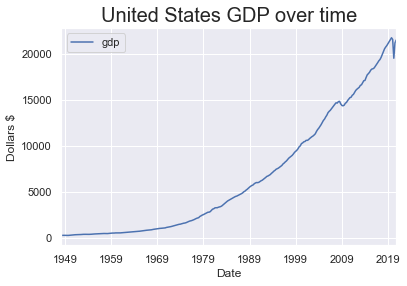

In [29]:
df['gdp'].plot()
plt.xlabel('Date')
plt.ylabel('Dollars $')
plt.title('United States GDP over time', fontsize = 20)
plt.legend()
plt.show()

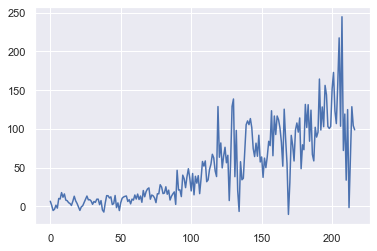

In [30]:
GDP_first_order = np.diff(y_train['gdp'])
plt.plot(GDP_first_order)

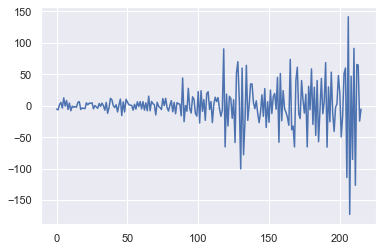

In [31]:
GDP_second_order = np.diff(GDP_first_order)
plt.plot(GDP_second_order)

In [32]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [33]:
adf_test(GDP_first_order)

Dickey-Fuller Test Result:
Test Statistic                  -0.320082
p-value                          0.922612
#Lags Used                      15.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [34]:
adf_gdp = adfuller(GDP_first_order)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: FALSE


In [35]:
adf_test(GDP_second_order)

Dickey-Fuller Test Result:
Test Statistic                -6.221139e+00
p-value                        5.219908e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


In [36]:
adf_gdp = adfuller(GDP_second_order)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [37]:
kpss_test(GDP_first_order)

KPSS Test Result:
Test Statistic            1.345519
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [38]:
kpss_gdp = kpss(GDP_first_order)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


In [39]:
kpss_test(GDP_second_order)

KPSS Test Result:
Test Statistic            0.050236
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [40]:
kpss_gdp = kpss(GDP_second_order)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


### 2.B - 7 pts Create and interpret ACF and PACF plots
- For stationarity, the entire distribution of has to be constant over time, not only its mean. We can easily see the mean of the data is constant, and it’s standard deviation is too. As t increases, the standard deviation of the data actually decreases!

- From another point of view, non-stationarity is tied to special points in time, and here t = 0 is special, since p0 is fixed to 1 here. An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
- For the PACF plot, the mean more or less remains constant. However there is more differences in standard deviation. We can also see more values that are not significant in this PACF plot throughout time.

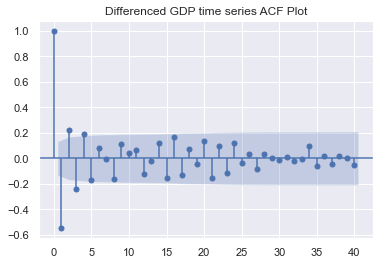

In [41]:
autocorr_plot = plot_acf(GDP_second_order, lags=40, title='Differenced GDP time series ACF Plot')

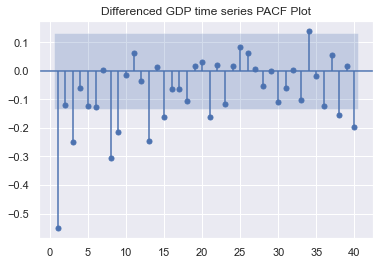

In [42]:
partial_autocorr_plot = plot_pacf(GDP_second_order, lags=40, title='Differenced GDP time series PACF Plot', zero = False)

### 2.C - 7 pts Fit an appropriate Box Jenkins model on training set

In [43]:
from sktime.forecasting.arima import ARIMA

In [44]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

In [45]:
df

,date,gdp,urate
0,1948-01-01,265.742,3.4
1,1948-04-01,272.567,3.9
2,1948-07-01,279.196,3.6
3,1948-10-01,280.366,3.7
4,1949-01-01,275.034,4.3
...,...,...,...
287,2019-10-01,21747.394,3.6
288,2020-01-01,21561.139,3.5
289,2020-04-01,19520.114,14.8
290,2020-07-01,21170.252,10.2


<AxesSubplot:xlabel='date'>

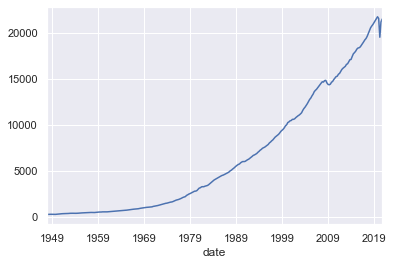

In [46]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['date'], freq="M"))['gdp'].mean()
ts.plot()

In [47]:
ts

date
1948-01      265.742
1948-04      272.567
1948-07      279.196
1948-10      280.366
1949-01      275.034
             ...    
2019-10    21747.394
2020-01    21561.139
2020-04    19520.114
2020-07    21170.252
2020-10    21494.731
Freq: M, Name: gdp, Length: 292, dtype: float64

In [48]:
#df = df.set_index(pd.DatetimeIndex(df['date']))
df.set_index('date', inplace = True)

In [49]:
adf_test(ts)

Dickey-Fuller Test Result:
Test Statistic                   3.522320
p-value                          1.000000
#Lags Used                       3.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [50]:
kpss_test(ts)
# we reject the null hypothesis- the new dataset is not stationary

KPSS Test Result:
Test Statistic            1.669461
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [51]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts)

In [52]:
print("Length of train set is " + str(y_train.shape[0]))
print("Length of test set is " + str(y_test.shape[0]))

Length of train set is 219
Length of test set is 73


## ARIMA

In [53]:
arima_model = ARIMA(order=(1,1,1))
arima_model_fit = arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

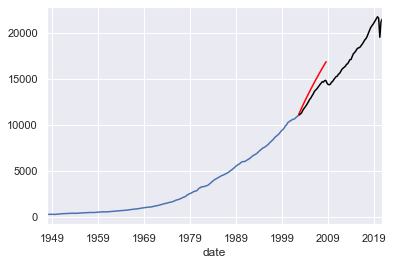

In [54]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [55]:
gdp_arima_mae = mean_absolute_percentage_error(y_test, y_pred)

## MA of ARIMA

In [56]:
ma_model = ARIMA(order=(0,0,1))
ma_model_fit = ma_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = ma_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

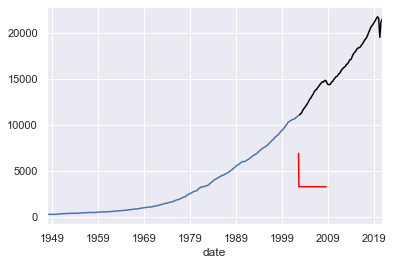

In [57]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [58]:
gdp_ma_mae = mean_absolute_percentage_error(y_test, y_pred)

## AR of ARIMA

In [59]:
from statsmodels.tsa.arima.model import ARIMA

In [60]:
ar_model = ARIMA(y_train, order=(1,0,0))

In [61]:
ar_model_fit = ar_model.fit()

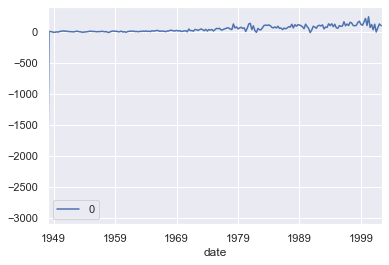

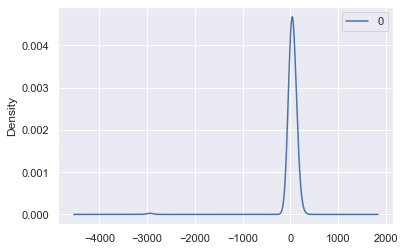

                 0
count   219.000000
mean     35.532522
std     207.852371
min   -2944.138073
25%       9.168542
50%      34.358469
75%      82.454070
max     245.293221


In [62]:
# residual checks
# line plot of residuals
residuals = pd.DataFrame(ar_model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### 2.D - 7 pts Check residuals (scatter plot, histogram, ACF, portmanteau tests) Give a summary of your residuals.

In [63]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

In [64]:
forecasting_index = ForecastingHorizon(y_test.index, is_relative=False)

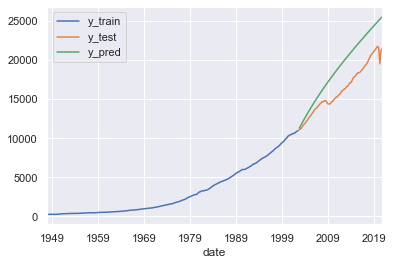

In [65]:
# model prediction

y_pred = arima_model_fit.predict(fh=forecasting_index)

plot_results(y_train, y_test, y_pred)

In [66]:
gdp_ar_mae = mean_absolute_percentage_error(y_test, y_pred)

In [67]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1032.315
Date:                Sat, 23 Apr 2022   AIC                           2072.630
Time:                        02:23:39   BIC                           2086.168
Sample:                             0   HQIC                          2078.098
                                - 219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5522      0.939      0.588      0.556      -1.288       2.392
ar.L1          0.9888      0.011     86.909      0.000       0.967       1.011
ma.L1         -0.7684      0.037    -20.593      0.000      -0.842      -0.695
sigma2       753.2053     43.341     17.379      0.000     668.259     838.151
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               162.26
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              31.24   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                  219
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1240.900
Date:                Sat, 23 Apr 2022   AIC                           2487.799
Time:                        02:23:39   BIC                           2497.967
Sample:                    01-31-1948   HQIC                          2491.906
                         - 07-31-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3209.8801      0.403   7966.554      0.000    3209.090    3210.670
ar.L1          0.9999      0.000   5367.210      0.000       1.000       1.000
sigma2      4692.5031    394.382     11.898      0.000    3919.528    5465.478
===================================================================================
Ljung-Box (L1) (Q):                 120.42   Jarque-Bera (JB):                42.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              98.93   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.62e+18. Standard errors may be unstable.
"""

In [69]:
ma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1929.143
Date:                Sat, 23 Apr 2022   AIC                           3864.287
Time:                        02:23:39   BIC                           3874.454
Sample:                             0   HQIC                          3868.393
                                - 219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3275.5387    313.213     10.458      0.000    2661.653    3889.424
ma.L1          1.0000      0.156      6.425      0.000       0.695       1.305
sigma2      2.574e+06   3.02e-05   8.52e+10      0.000    2.57e+06    2.57e+06
===================================================================================
Ljung-Box (L1) (Q):                 212.99   Jarque-Bera (JB):                34.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+31. Standard errors may be unstable.
"""

### 2.E - 7 pts Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

In [70]:
gdp_arima_mae

0.13321566911425384

In [71]:
gdp_ma_mae

1.3060430592290948

In [72]:
gdp_ar_mae

0.1477365158892039

## 3. 35 pts – Box Jenkins model for Unemployment rate
### 3.A - 7 pts Perform transformations or differencing until you can visually and statistically prove stationarity on training set. Summarize the changes to your time series.

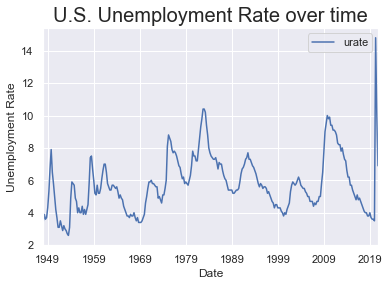

In [73]:
df['urate'].plot()
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('U.S. Unemployment Rate over time', fontsize = 20)
plt.legend()
plt.show()

In [74]:
y_train, y_test = temporal_train_test_split(df)

In [75]:
print("Length of train set is " + str(y_train.shape[0]))
print("Length of test set is " + str(y_test.shape[0]))

Length of train set is 219
Length of test set is 73


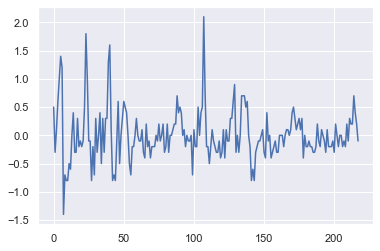

In [76]:
urate_first_order = np.diff(y_train['urate'])
plt.plot(urate_first_order)

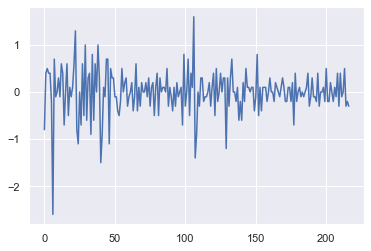

In [77]:
urate_second_order = np.diff(urate_first_order)
plt.plot(urate_second_order)

In [78]:
adf_test(urate_first_order)

Dickey-Fuller Test Result:
Test Statistic                  -5.277430
p-value                          0.000006
#Lags Used                       8.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [79]:
adf_urate = adfuller(urate_first_order)
ad_fuller_pval = adf_urate[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [80]:
kpss_test(urate_first_order)

KPSS Test Result:
Test Statistic            0.068683
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [81]:
kpss_urate = kpss(urate_first_order)
kpss_pval = kpss_urate[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


### 3.B - 7 pts Create and interpret ACF and PACF plots

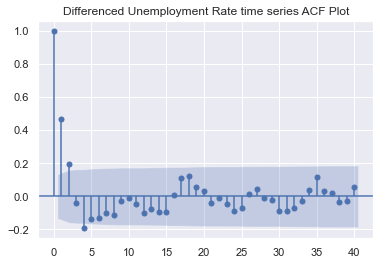

In [82]:
autocorr_plot = plot_acf(urate_first_order, lags=40, title='Differenced Unemployment Rate time series ACF Plot')

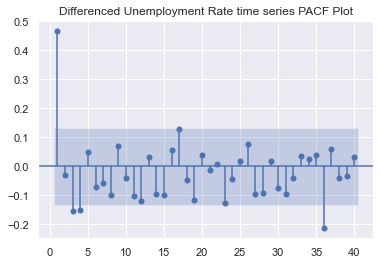

In [83]:
partial_autocorr_plot = plot_pacf(urate_first_order, lags=40, title='Differenced Unemployment Rate time series PACF Plot', zero = False)

### 3.C - 7 pts Fit an appropriate Box Jenkins model on training set

In [84]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

<AxesSubplot:xlabel='date'>

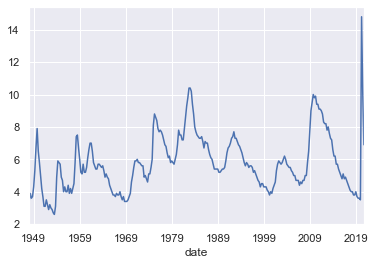

In [85]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['date'], freq="M"))['urate'].mean()
ts.plot()

In [86]:
df.set_index('date', inplace = True)

In [87]:
adf_test(ts)

Dickey-Fuller Test Result:
Test Statistic                  -4.385167
p-value                          0.000315
#Lags Used                       0.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


In [88]:
kpss_test(ts)
# cannot reject the null hypothesis- the new dataset is stationary

KPSS Test Result:
Test Statistic            0.314287
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## ARIMA

In [89]:
from sktime.forecasting.arima import ARIMA

In [90]:
y_train, y_test = temporal_train_test_split(ts)

In [91]:
print("Length of train set is " + str(y_train.shape[0]))
print("Length of test set is " + str(y_test.shape[0]))

Length of train set is 219
Length of test set is 73


In [92]:
arima_model = ARIMA(order=(1,1,1))
arima_model_fit = arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

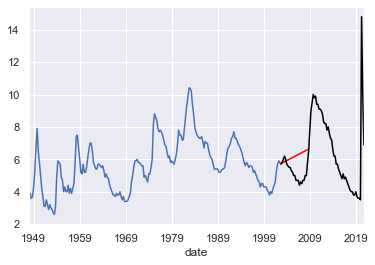

In [93]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [94]:
urate_arima_mae = mean_absolute_percentage_error(y_test, y_pred)

## MA of ARIMA

In [95]:
from sktime.forecasting.arima import ARIMA

In [96]:
ma_model = ARIMA(order=(0,0,1))
ma_model_fit = ma_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = ma_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

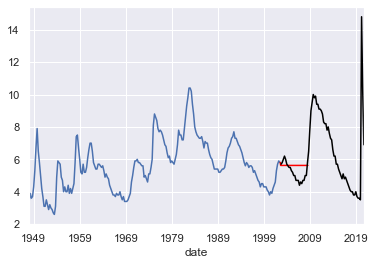

In [97]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [98]:
urate_ma_mae = mean_absolute_percentage_error(y_test, y_pred)

## AR of ARIMA

In [99]:
from statsmodels.tsa.arima.model import ARIMA

In [100]:
ar_model = ARIMA(y_train, order=(1,0,0))

In [101]:
ar_model_fit = ar_model.fit()

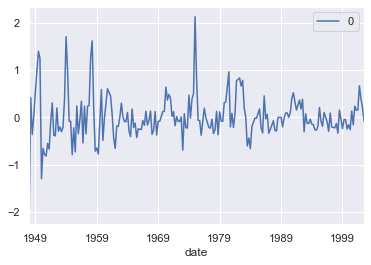

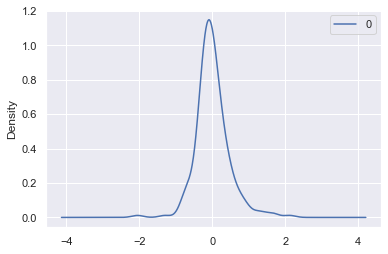

                0
count  219.000000
mean     0.008975
std      0.463494
min     -2.050297
25%     -0.224723
50%     -0.047374
75%      0.186474
max      2.122639


In [102]:
# residual checks
# line plot of residuals
residuals = pd.DataFrame(ar_model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [103]:
urate_ar_mae = mean_absolute_percentage_error(y_test, y_pred)

### 3.D - 7 pts Check residuals (scatter plot, histogram, ACF, portmanteau tests)  Give a summary of your residuals.

In [104]:
forecasting_index = ForecastingHorizon(y_test.index, is_relative=False)

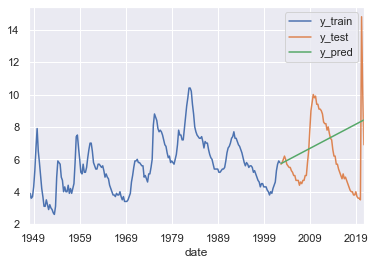

In [105]:
# model prediction

y_pred = arima_model_fit.predict(fh=forecasting_index)

plot_results(y_train, y_test, y_pred)

In [106]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -107.338
Date:                Sat, 23 Apr 2022   AIC                            222.676
Time:                        02:23:41   BIC                            236.214
Sample:                             0   HQIC                           228.145
                                - 219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0071      0.034      0.210      0.833      -0.059       0.073
ar.L1          0.4306      0.101      4.284      0.000       0.234       0.628
ma.L1          0.0458      0.132      0.346      0.730      -0.214       0.305
sigma2         0.1566      0.009     17.639      0.000       0.139       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               215.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  urate   No. Observations:                  219
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -133.717
Date:                Sat, 23 Apr 2022   AIC                            273.434
Time:                        02:23:41   BIC                            283.601
Sample:                    01-31-1948   HQIC                           277.540
                         - 07-31-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4503      0.699      7.797      0.000       4.080       6.820
ar.L1          0.9588      0.018     52.255      0.000       0.923       0.995
sigma2         0.1963      0.012     15.943      0.000       0.172       0.220
===================================================================================
Ljung-Box (L1) (Q):                  47.96   Jarque-Bera (JB):               176.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
ma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -280.125
Date:                Sat, 23 Apr 2022   AIC                            566.251
Time:                        02:23:41   BIC                            576.418
Sample:                             0   HQIC                           570.357
                                - 219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.6240      0.117     48.106      0.000       5.395       5.853
ma.L1          0.9320      0.021     43.362      0.000       0.890       0.974
sigma2         0.7491      0.072     10.439      0.000       0.608       0.890
===================================================================================
Ljung-Box (L1) (Q):                 119.30   Jarque-Bera (JB):                 6.91
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.54   Skew:                             0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.E - 7 pts Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

In [109]:
urate_arima_mae

0.26706338469109664

In [110]:
urate_ma_mae

0.25296693964198164

In [111]:
urate_ar_mae

0.25296693964198164

## 4. 10 pts – Evaluation Compare the two models’ performance using the error metrics as evidence
- We ran 3 models each for GDP and urate, respectively. The models were ARIMA, MA, and AR. The models were fit after verifying stationarity in the data, and after splitting between train and test sets.
- Generally, we found the error to have greater variance between the models' performance when fit to GDP data in comparison to urate data. However this was only due to the MA model in GDP. We suspect this model had overfitting, or the parameters should be adjusted to be higher order. Excluding the MA model in GDP, the errors were lower (13-14% compared to average error for the models in urate (25-26%). This means the difference between the original and predicted values extracted by averaged the absolute difference over the data sets were lower for GDP model performance compared to urate models.